# 0.0 Imports 

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

import math
import datetime
import warnings
import inflection


from scipy                 import stats  as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib            import pyplot as plt
from sklearn.metrics       import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error
from IPython.display       import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder

## 0.1 Loading Data

In [2]:
df_store_raw = pd.read_csv('Data/store.csv', low_memory = False )

df_train_raw = pd.read_csv('Data/train.csv' , low_memory = False )

#merge
df_raw = pd.merge( df_train_raw , df_store_raw, how = 'left', on='Store')

## 0.2 Helper Functions 

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
    
   

In [4]:
def mape2( y, yhat ):
    return np.mean( np.abs( (y - yhat) / y ) )

def ml_error( model, y , yhat):
    mae  = np.round( mean_absolute_error( y , yhat) , 2 ) 
    mape = np.round( mape2( y , yhat ) , 2)
    rmse = np.round( np.sqrt( mean_squared_error(y , yhat ) ) , 2)
    
    return pd.DataFrame( {'Model Name': model,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])
    
    

In [5]:
def get_model_performance(models, x_train,y_train,x_test,y_test):
    
    #create dataframe
    df_performance = pd.DataFrame()
    
    for model in models:
        
        print("Training" + type(model).__name__ + "...")
        
        #fit model
        model.fit( x_train, y_train )
        
        #prediction
        yhat = model.predict( x_test )
        
        #performance
        df = ml_error(type(model).__name__ , np.expm1( y_test ), np.expm1( yhat ) )
        
        #concat
        df_performance = pd.concat( [df_performance, df ] )
        
        #reset index
        df_performance = df_performance.reset_index()
        
        # drops index
        df_performance.drop('index', axis=1, inplace=True)
        

        
    return df_performance


In [6]:
def models_cross_validation(models, x_training):
    
    df_performance = pd.DataFrame()
    
    for model in models:
    
        print("Training... " +type(model).__name__ + "..." )
        mae  = []
        mape = []
        rmse = []
        for k in reversed(range(1 , 6 ) ):


            print("Iteration {}".format( k ))

            valid_start = x_training['date'].max() - datetime.timedelta( days = k*6*7)
            valid_end = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

            #filtering dataset
            training = x_training[x_training['date'] < valid_start]
            validation = x_training[ ( x_training['date'] >=valid_start ) & ( x_training['date'] <= valid_end ) ]

            #train and validation dataset
            #training
            xtrain = training.drop( ['date','sales'], axis=1 )
            ytrain = training['sales']

            #validation
            xvalid = validation.drop( [ 'date','sales'], axis=1)
            yvalid = validation['sales']

            #model
            model.fit( xtrain, ytrain )

            #predict
            yhat = model.predict( xvalid)

            #performance
            df = ml_error((type(model).__name__  + "  KFold: {}".format(k) ), np.expm1( yvalid ), np.expm1( yhat ) )
            
            mae.append( df['MAE'] )
            mape.append( df['MAPE'] )
            rmse.append( df['RMSE'] )
            #concat
            df_performance = pd.concat( [df_performance, df ] )

            #reset index
            df_performance = df_performance.reset_index()

            # drops index
            df_performance.drop('index', axis=1, inplace=True)
        
        mae_cv  = np.round( np.mean( mae ) , 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae ) , 2 ).astype( str )
        mape_cv = np.round( np.mean( mape ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape ) , 2 ).astype( str )
        rmse_cv = np.round( np.mean( rmse ), 2 ).astype( str ) + " +/- " + np.round( np.std( rmse ) , 2 ).astype( str )
        
        df_cv =  pd.DataFrame( {
        'Model Name': ( type(model).__name__ + " - Cross-Validation "),    
        'MAE':mae_cv ,
        'MAPE':mape_cv  ,
        'RMSE':rmse_cv }
            , index=[0])
    
        #concat
        df_performance = pd.concat( [df_performance, df_cv ] )
        
        #reset index
        df_performance = df_performance.reset_index()

        # drops index
        df_performance.drop('index', axis=1, inplace=True)

    
    return df_performance


In [7]:
jupyter_settings()
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data Description

In [8]:
df1 = df_raw.copy()

## 1.1 Rename Columns 

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

df1.columns


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions 

In [11]:
print(" Number of rows {}".format( df1.shape[0] ) )
print(" Number of cols {}".format( df1.shape[1] ) )

 Number of rows 1017209
 Number of cols 18


## 1.3 Data Types 

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Let's change the date variable to the datetime type

In [13]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.1 Fillout NA

In **competition distance** I will assume that for NA values it is because there is no competitor around so I will put a much higher value than the maximum.


In [15]:
# competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'] , axis =1 )


# competition_open_since_year     

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'] , axis =1 )

#promo2_since_week                               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis =1 )

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis =1 )

# promo_interval                  
month_map = {1:  'Jan', 2:  'Feb',3:  'Mar', 4:  'Apr', 5:  'May', 6:  'Jun', 7:  'Jul', 8:  'Aug', 9:  'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1['promo_interval'].fillna(0 , inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x ['promo_interval'].split( ',' ) else 0 , axis = 1 )






In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

As observed, we treat all NA in dataset

## 1.6 Change Types 

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )



## 1.7 Descriptive Statistical 

In [18]:
num_att = df1.select_dtypes( include = ['int64' , 'float64'] )
cat_att = df1.select_dtypes( exclude = ['int64' , 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes 

In [19]:
#central tendency - mean, meadian

ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

#Dispersion -std, min , max , range , skew ,kurtosis
d1 = pd.DataFrame( num_att.apply( np.std ) ).T
d2 = pd.DataFrame( num_att.apply( min ) ).T
d3 = pd.DataFrame( num_att.apply( max ) ).T
d4 = pd.DataFrame( num_att.apply( lambda x : x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply( lambda x : x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply( lambda x : x.kurtosis() ) ).T


#concat
m = pd.concat( [d2 , d3 , d4,ct1 , ct2 ,d1,d5 ,d6]).T.reset_index()
m.columns = ['attributes' , 'min' , 'max' , 'range' ,'mean' ,'median' , 'std', 'skew' , 'kurtosis']

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes 

In [20]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

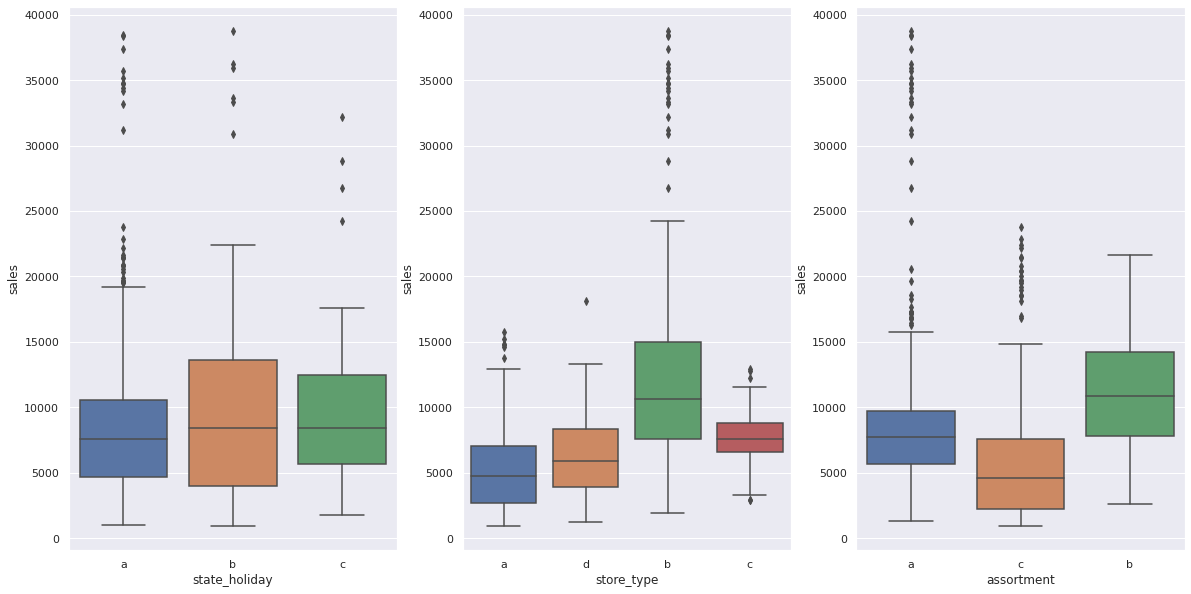

In [21]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 ) ]

plt.subplot(1 , 3 ,1)
sns.boxplot( x='state_holiday' , y = 'sales' ,data = aux1)

plt.subplot(1 , 3 ,2)
sns.boxplot( x='store_type' , y = 'sales' ,data = aux1)


plt.subplot(1 , 3 ,3)
sns.boxplot( x='assortment' , y = 'sales' ,data = aux1)

**Store Type** = B has the highest median sales and **assortment** = b as well 

# 2.0 Feature Engineering 

In [22]:
df2 = df1.copy()

## 2.1 Mind Map 

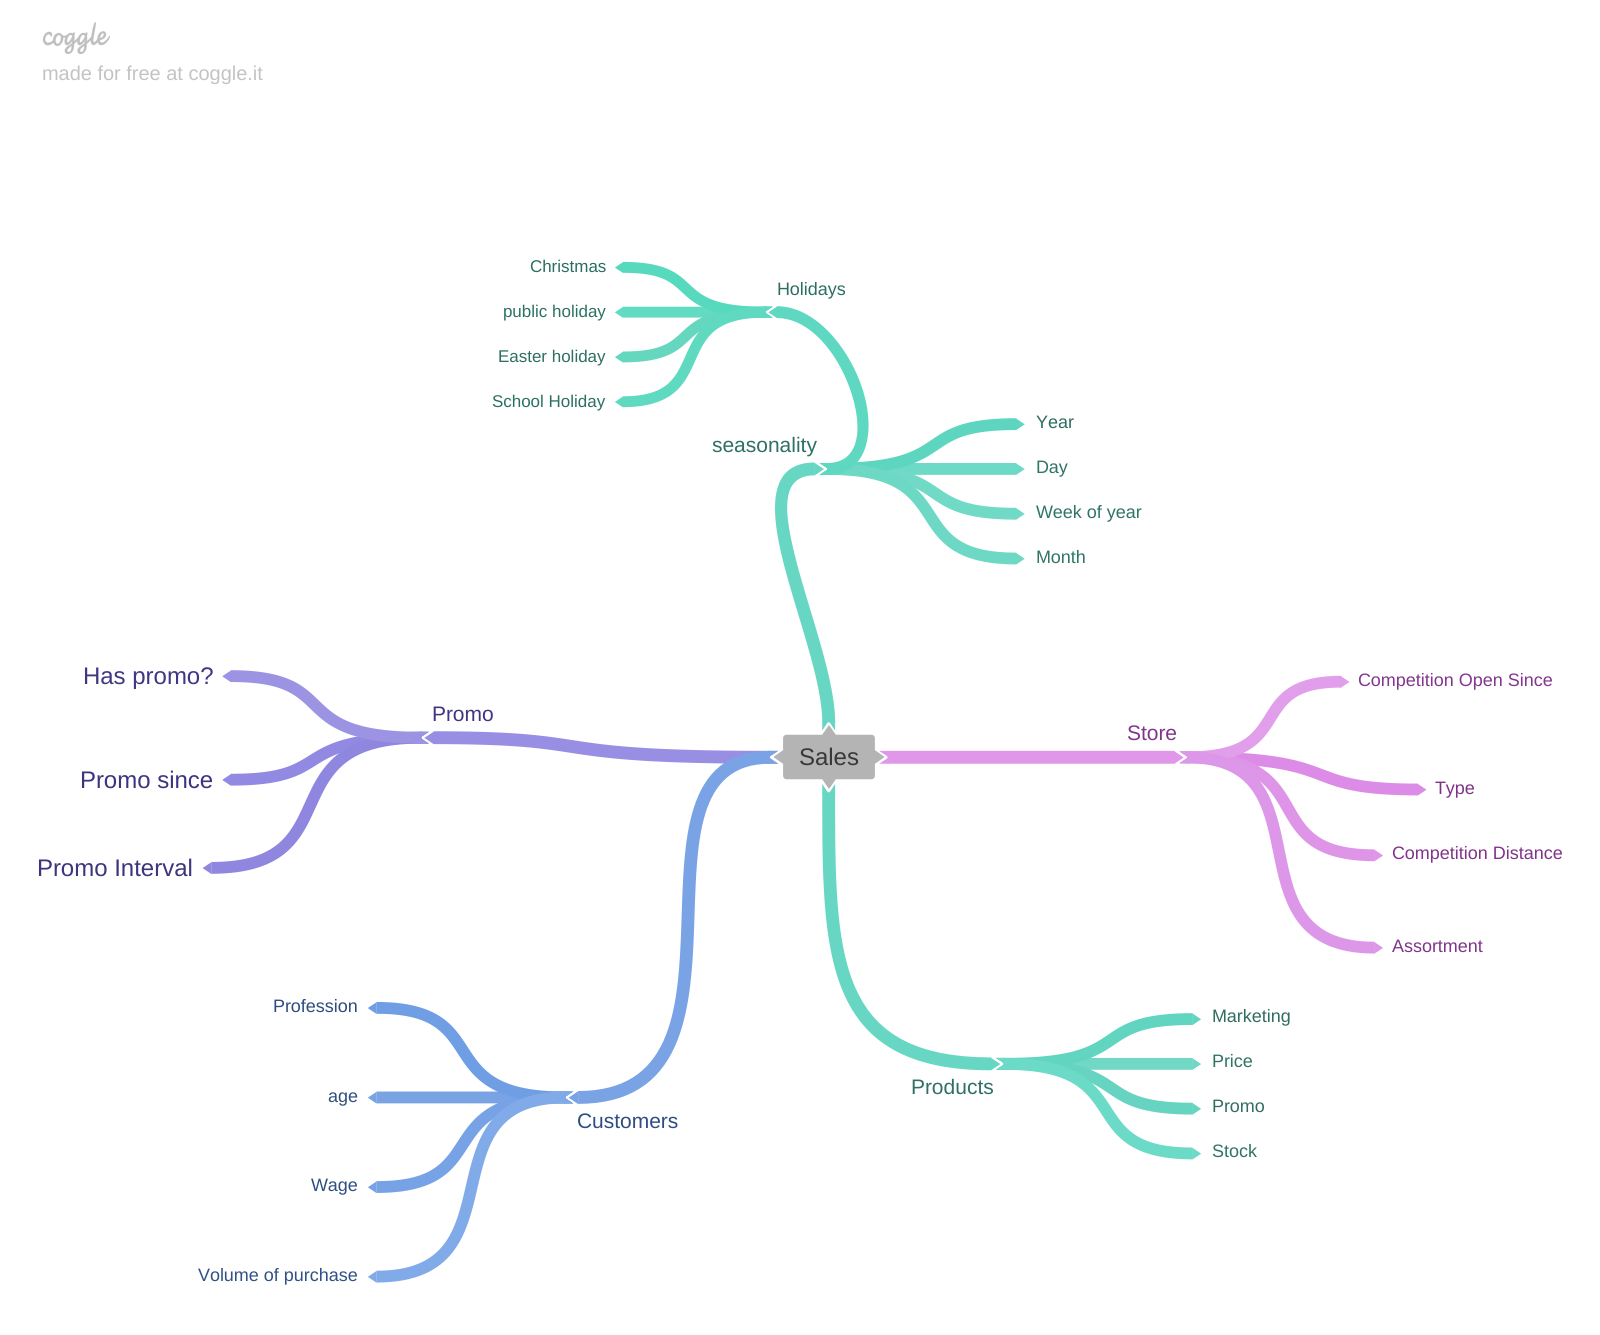

In [23]:

Image(filename='img/Sales.png')

## 2.2 Creating Hypotheses

### 2.2.1 Store Hypotheses

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with a higher inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.


**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.2.2 Product Hypotheses

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts), should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more

### 2.2.1 Seasonality Hypotheses

**1.**Stores open during the Christmas holiday should sell more.

**2.**Stores should sell more over the years.

**3.**Stores should sell more in the second half of the year.

**4.**Stores should sell more after the 10th of each month.

**5.**Stores should sell less on weekends.

**6.**Stores should sell less during school holidays.

## 2.3 Final list of hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.




**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10**. Stores should sell more after the 10th of each month.

**11**. Stores should sell less on weekends.

**12**. Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [24]:
#year
df2['year'] = df2['date'].dt.year
#month

df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since']     = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 )  )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

#assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )




# 3.0 Data Filtering

In [25]:
df3 = df2.copy()

## 3.1 Rows Filtering  

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Columns Filtering  

In [27]:
cols_drop = ['customers', 'open', 'month_map' , 'promo_interval']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Exploratory Data Analysis 

In [28]:
df4 = df3.copy()

## 4.1  Univariate Analysis

### 4.1.1 Response Variable 

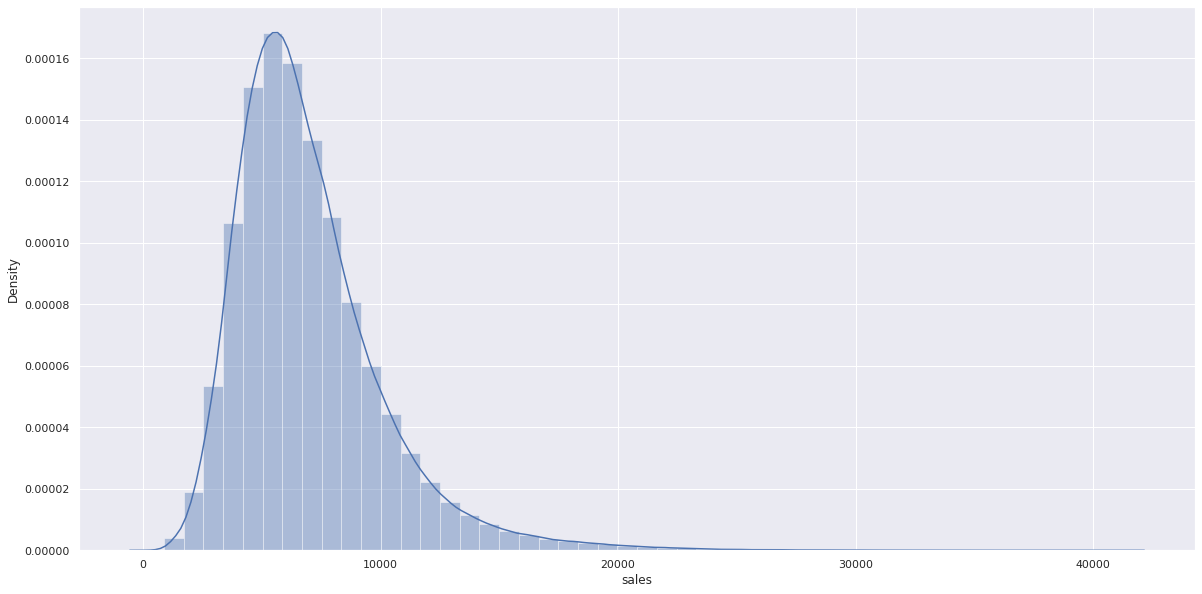

In [29]:
sns.distplot( df4['sales'] );

### 4.1.2 Numerical Variable 

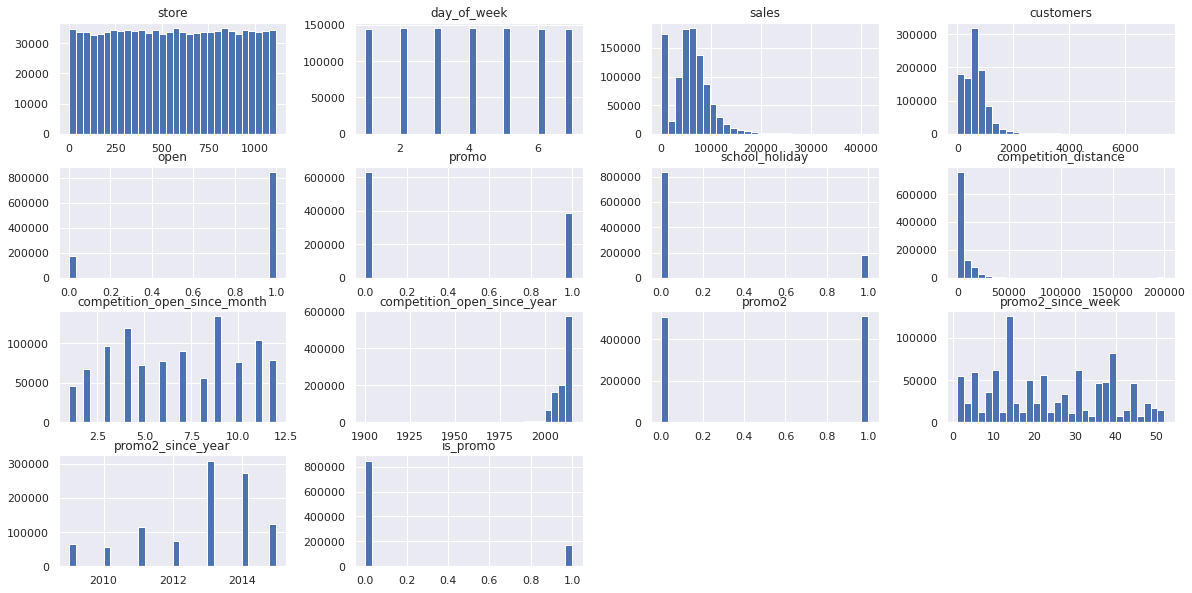

In [30]:
num_att.hist( bins = 30 );

### 4.1.3 Categorical Variable 

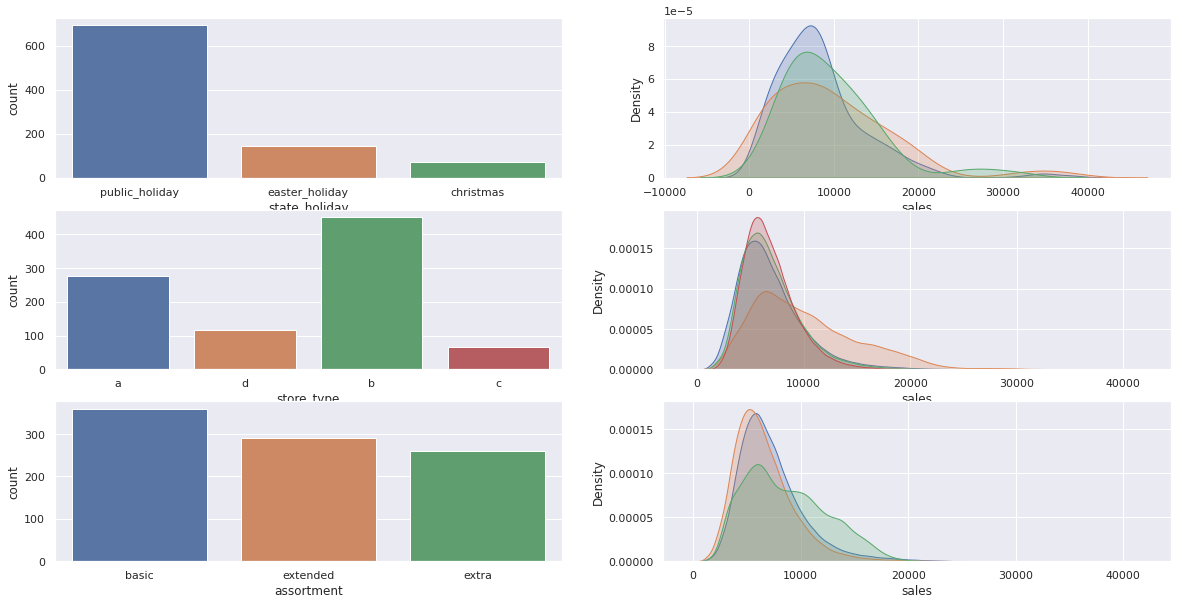

In [31]:
#state holiday
plt.subplot( 3, 2, 1 ) 
aux413 = df4[df4['state_holiday'] != 'regular_day' ]
sns.countplot( aux413['state_holiday'] );

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday',shade = True )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday',shade = True )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas',shade = True );


#state holiday
plt.subplot( 3, 2, 3 ) 
sns.countplot( aux413['store_type'] );



plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a',shade = True )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b',shade = True )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c',shade = True )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd' ,shade = True )

#state holiday
plt.subplot( 3, 2, 5 )
sns.countplot( aux413['assortment'] );



plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended',shade = True )
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic',shade = True )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra',shade = True );



## 4.2  Bivariate Analysis

### **H1.** Stores with a larger assortment should sell more on average.
###  **True**


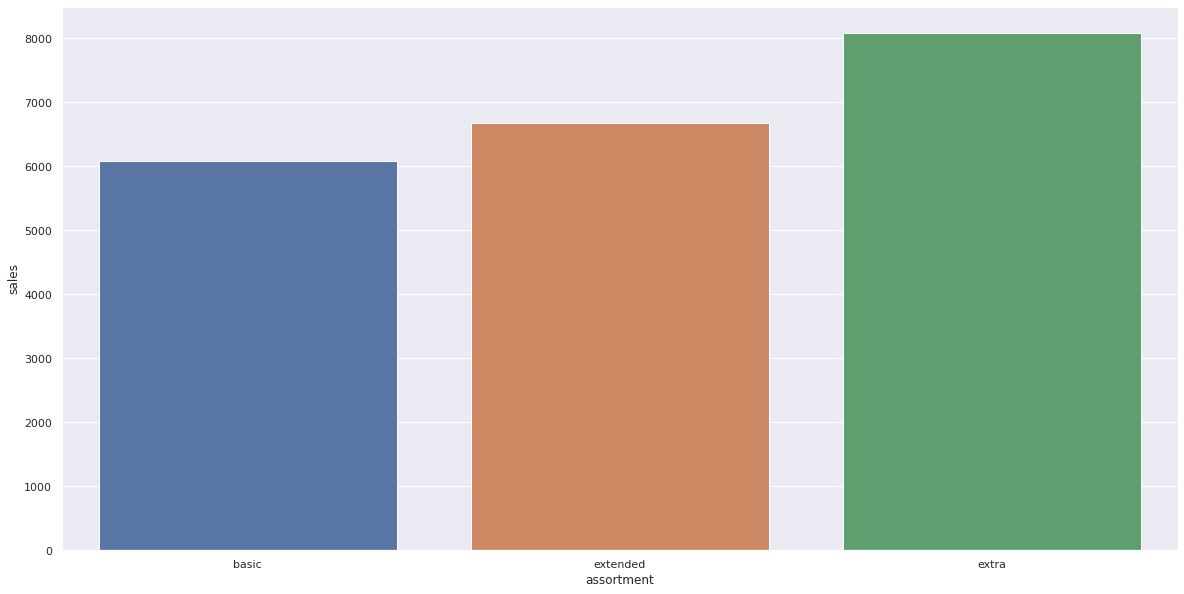

In [32]:
auxh1 = df4[['assortment','sales']].groupby( 'assortment' ).median().reset_index()

sns.barplot(x='assortment' , y= 'sales', data= auxh1 );


### **H2.** Stores with closer competitors should sell less.
### **False**



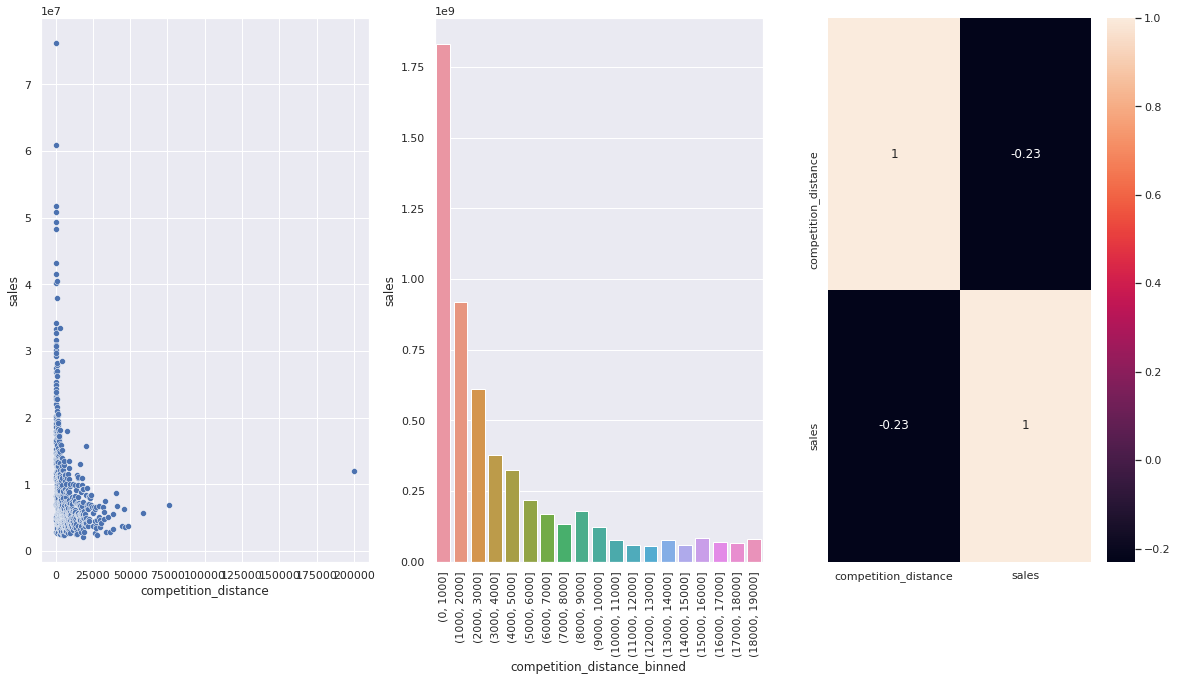

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Stores with longer competitors should sell more.
### **False**


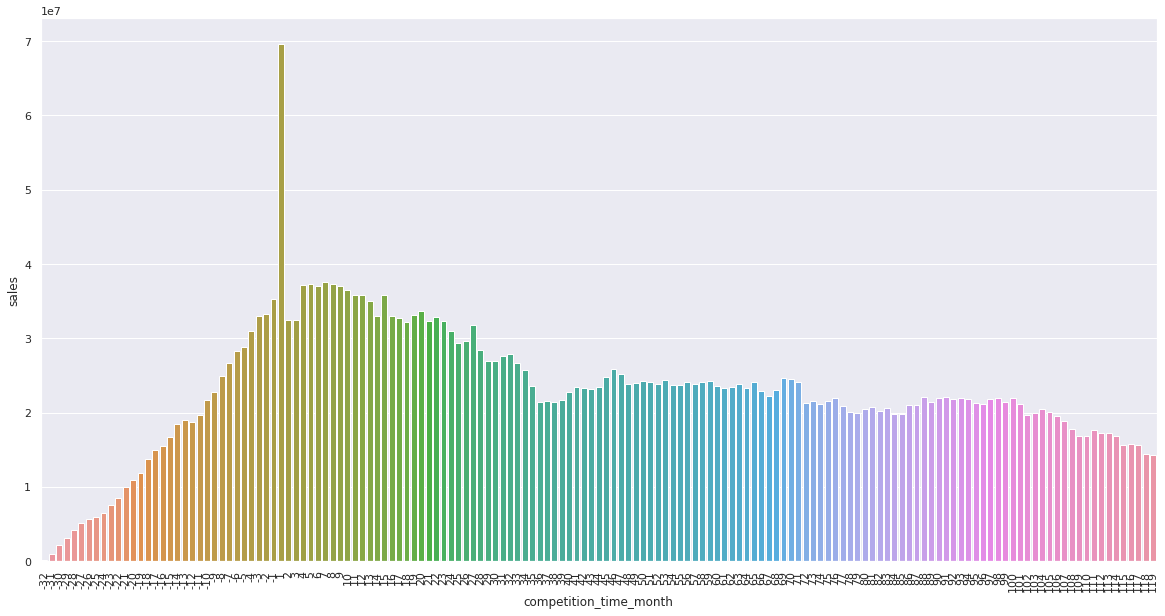

In [34]:
aux3 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').sum().reset_index()
aux4 = aux3[( aux3['competition_time_month'] < 120 ) & (aux3['competition_time_month'] != 0 )]
sns.barplot( x = 'competition_time_month', y='sales', data=aux4 );
plt.xticks(rotation= 90);



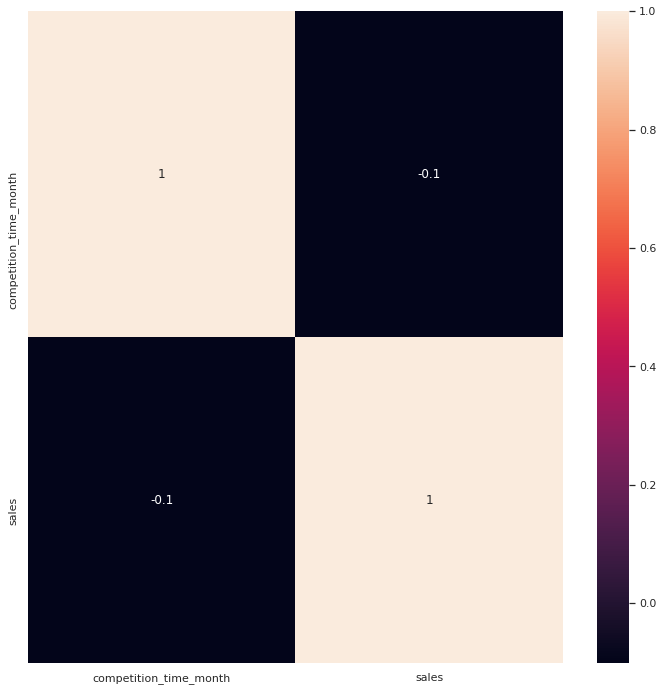

In [35]:
plt.figure( figsize=(12,12))
sns.heatmap( aux3.corr(method='pearson'), annot=True );

### **H4.** Stores with active promotions for longer should sell more.
### **False**


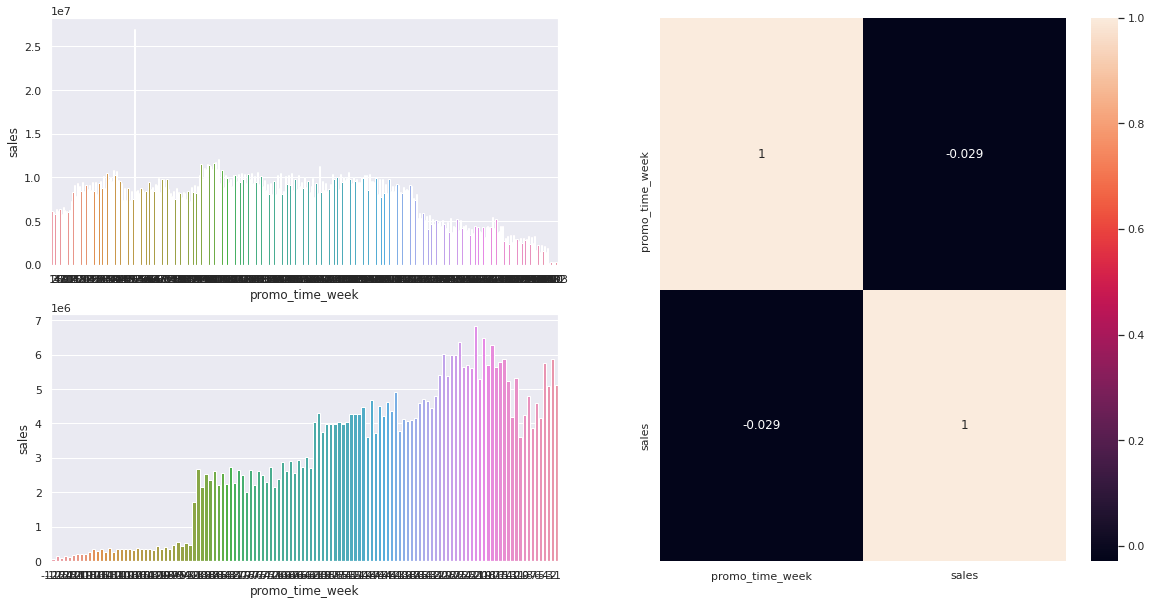

In [36]:
aux4 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec(2,2)
plt.subplot( grid[0,0] )
#extended promotion
aux2 = aux4[aux4['promo_time_week'] > 0 ]
sns.barplot( x='promo_time_week' , y='sales', data=aux2);

plt.subplot( grid[1,0] )
#regular promotion
aux3 = aux4[aux4['promo_time_week'] < 0 ]
sns.barplot( x='promo_time_week' , y='sales', data=aux3);

plt.subplot( grid[:, 1 ]  )

sns.heatmap(aux4.corr(method='pearson'), annot=True);

### **H5.** Stores with more consecutive promotions should sell more.
### False

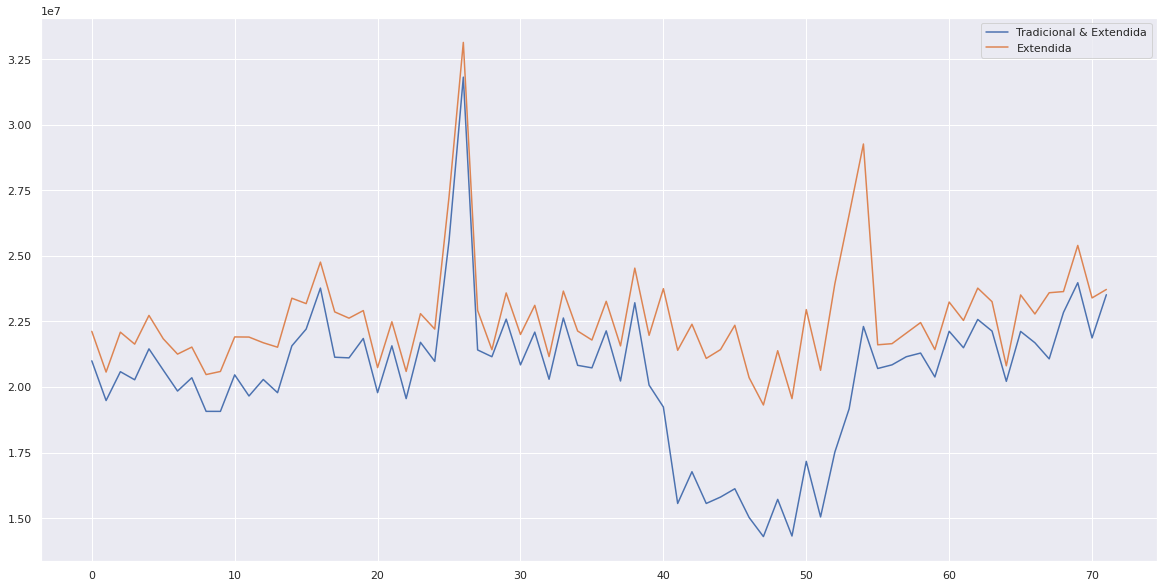

In [37]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H6.** Stores open during the Christmas holiday should sell more.
### **False**


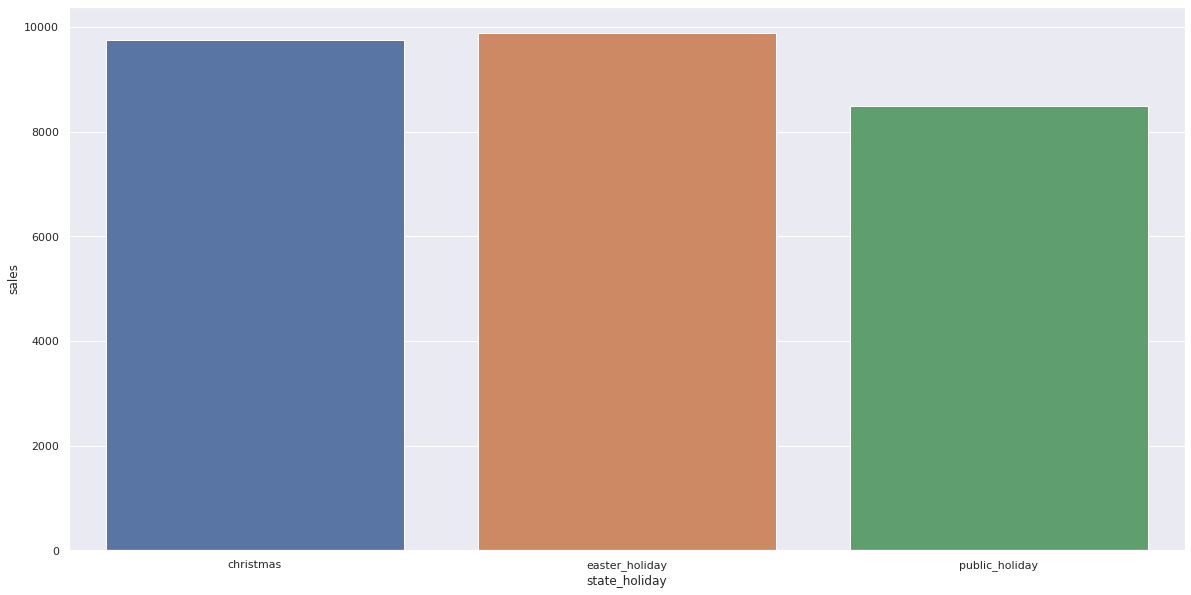

In [38]:
aux7 = df4[['state_holiday','sales']].groupby( 'state_holiday' ).mean().reset_index()
aux8 = aux7[aux7['state_holiday'] != 'regular_day']

sns.barplot(x='state_holiday', y='sales' ,data=aux8);


### **H7.** Stores should sell more over the years.
### **False**

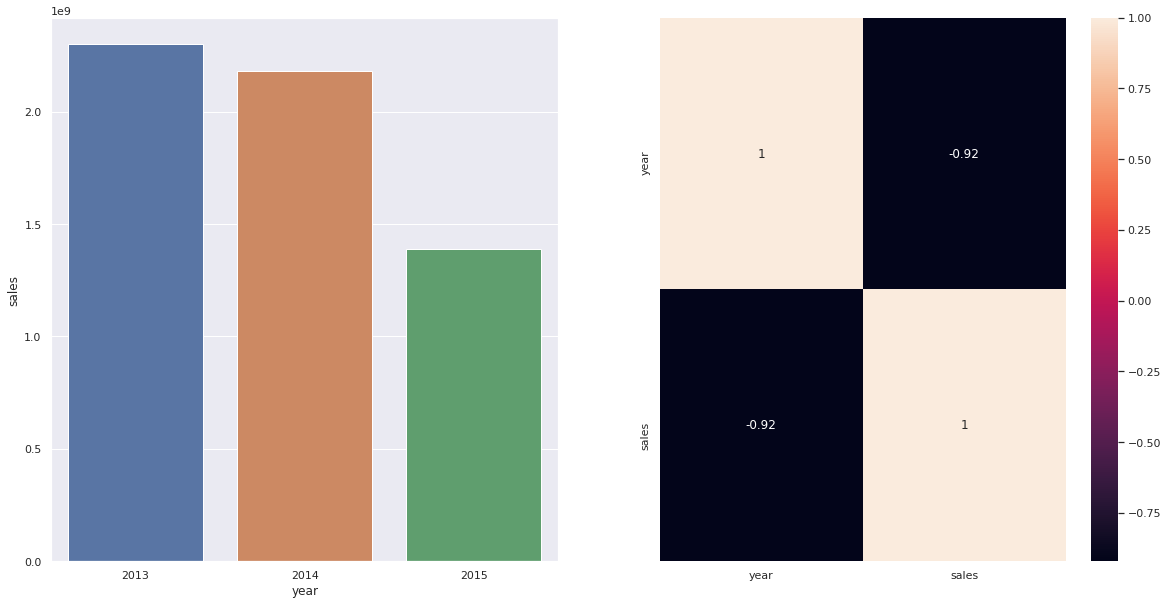

In [39]:
aux8 = df4[['sales','year']].groupby('year').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='year', y='sales', data=aux8);
plt.subplot(1,2,2)
sns.heatmap(aux8.corr(method='pearson'), annot=True );


### **H8.** Stores should sell more in the second half of the year.
### **True**

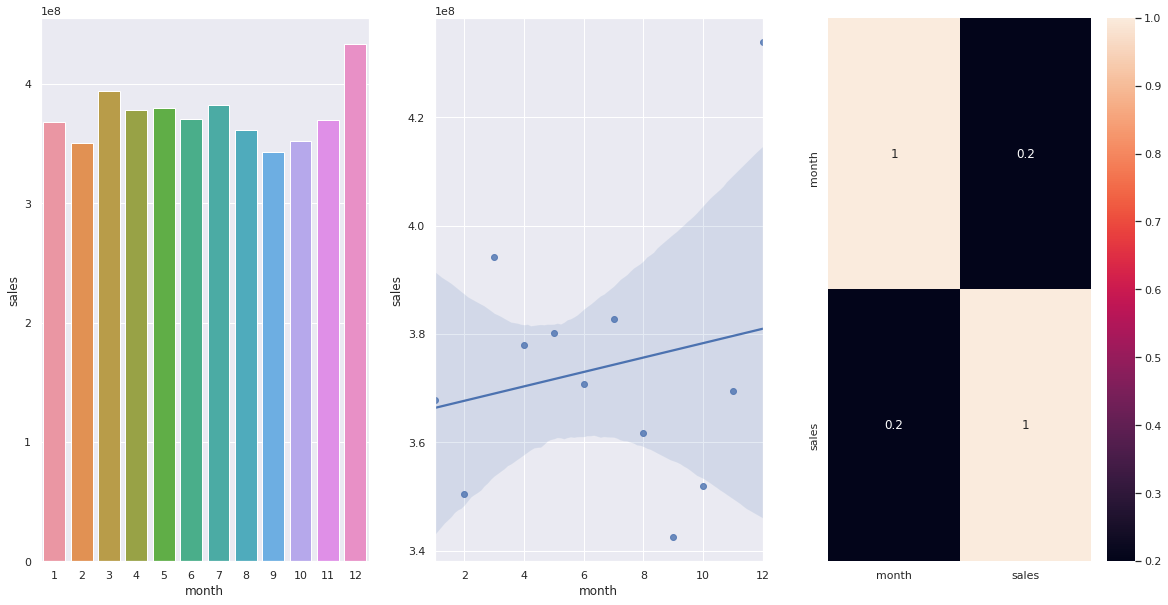

In [40]:
aux9 = df4[df4['year'] != 2015 ]

aux8 = aux9[['sales','month']].groupby('month').sum().reset_index()
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux8);
plt.subplot(1,3,3)
sns.heatmap(aux8.corr(method='pearson'), annot=True );

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux8);

### **H9**. Stores should sell more after the 10th of each month.
 ### **True**




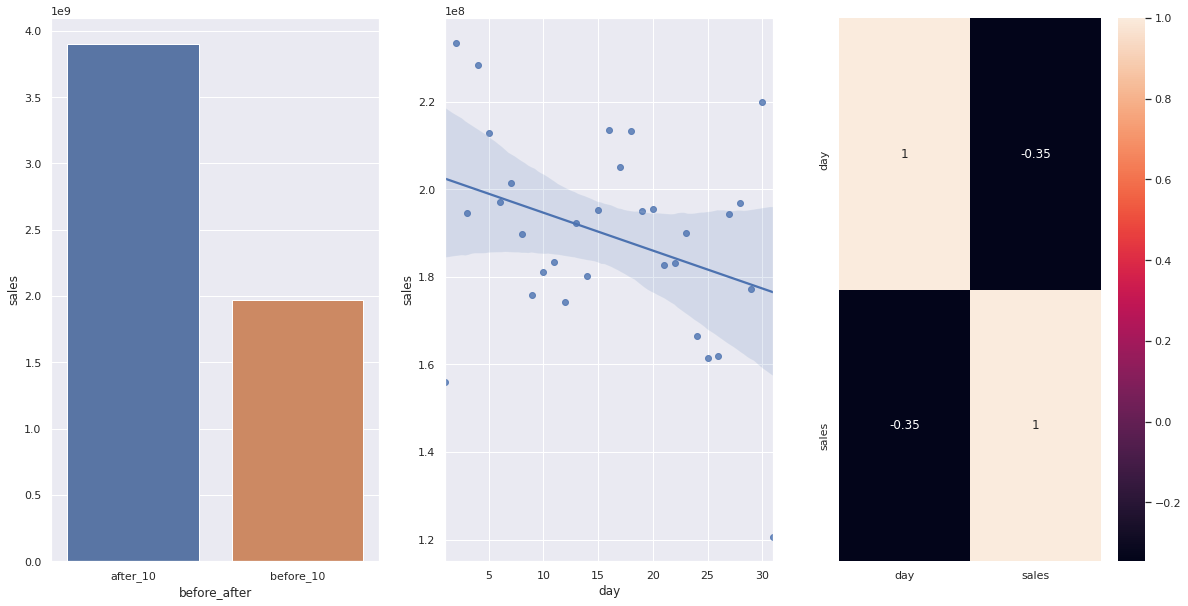

In [41]:

aux8 = df4[['sales','day']].groupby('day').sum().reset_index()
plt.subplot(1,3,2)

sns.regplot(x='day', y='sales', data=aux8);

plt.subplot(1,3,3)

sns.heatmap(aux8.corr(method='pearson'), annot=True );

plt.subplot(1,3,1)

aux8['before_after'] = aux8['day'].apply( lambda x: 'before_10' if x <=10 else 'after_10')

aux9 = aux8[['before_after','sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', data=aux9);

### **H10**. Stores should sell less on weekends on average.
###  Sells a lot **less** on **Saturday** but **sells a lot on Sunday**


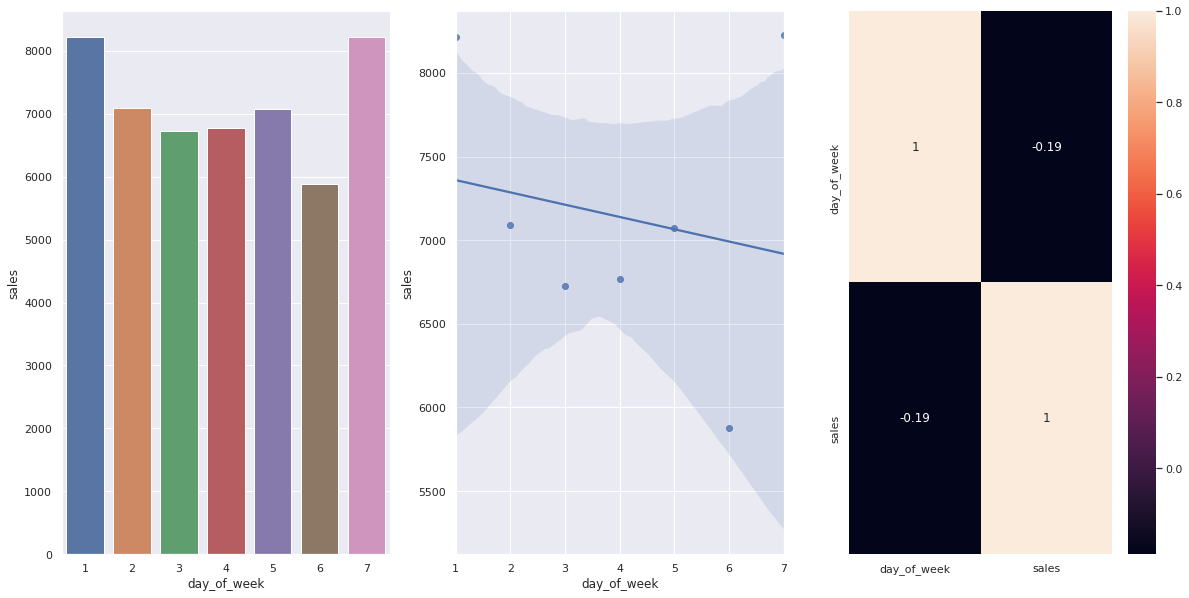

In [42]:

aux8 = df4[['sales','day_of_week']].groupby('day_of_week').mean().reset_index()
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux8);
plt.subplot(1,3,3)
sns.heatmap(aux8.corr(method='pearson'), annot=True );

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux8);

### **H11**. Stores should sell less  on average during school holidays 
### **False** except in December

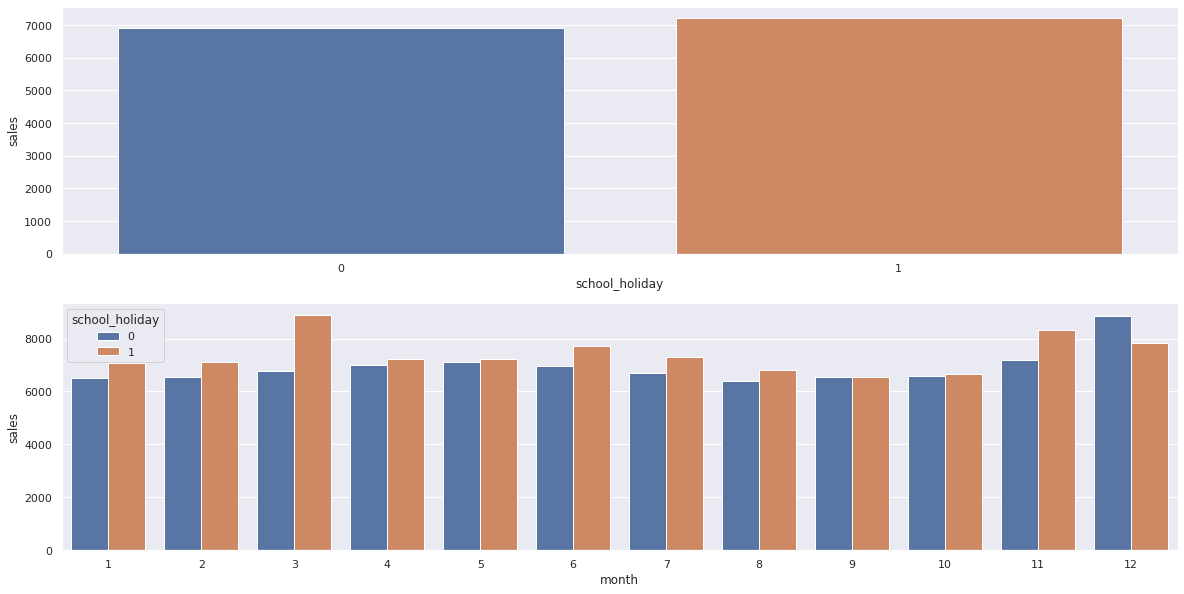

In [43]:

aux8 = df4[['sales','school_holiday']].groupby('school_holiday').mean().reset_index()
aux9 = df4[['sales','month','school_holiday']].groupby(['month','school_holiday']).mean().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux9);

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux8);

### 4.2.1 Summary of Hypotheses

In [44]:
tab=[
    ['H1','True' ,'High'],
    ['H2','False','Medium'],
    ['H3','False','Low'],
    ['H4','False','Low'],
    ['H5','False','Low'],
    ['H6','False','Low'],
    ['H7','False','High'],
    ['H8','True','Medium'],
    ['H9','True','Medium'],
    ['H10','False','Medium'],
    ['H11','False','Low'],
    ]
#a = tabulate(tab, headers='firstrow')
b = pd.DataFrame(data= tab, columns=['Hypotheses','Conclusion','Relevance'])
b


,Hypotheses,Conclusion,Relevance
0,H1,True,High
1,H2,False,Medium
2,H3,False,Low
3,H4,False,Low
4,H5,False,Low
5,H6,False,Low
6,H7,False,High
7,H8,True,Medium
8,H9,True,Medium
9,H10,False,Medium


## 4.3  Multivariate Analysis

###  4.3.1 Numerical Attributes

<AxesSubplot:>

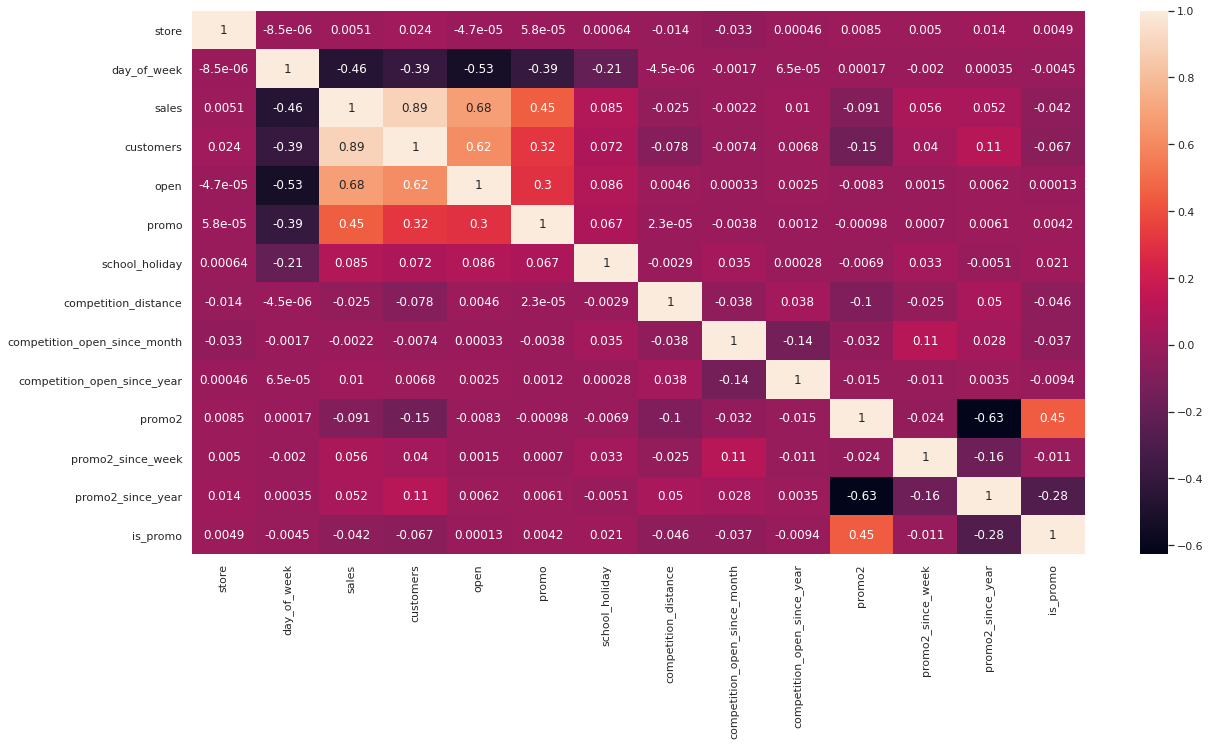

In [45]:
corr = num_att.corr(method='pearson')
sns.heatmap(corr, annot=True)

### 4.3.2 Categorical Attributes 

<AxesSubplot:>

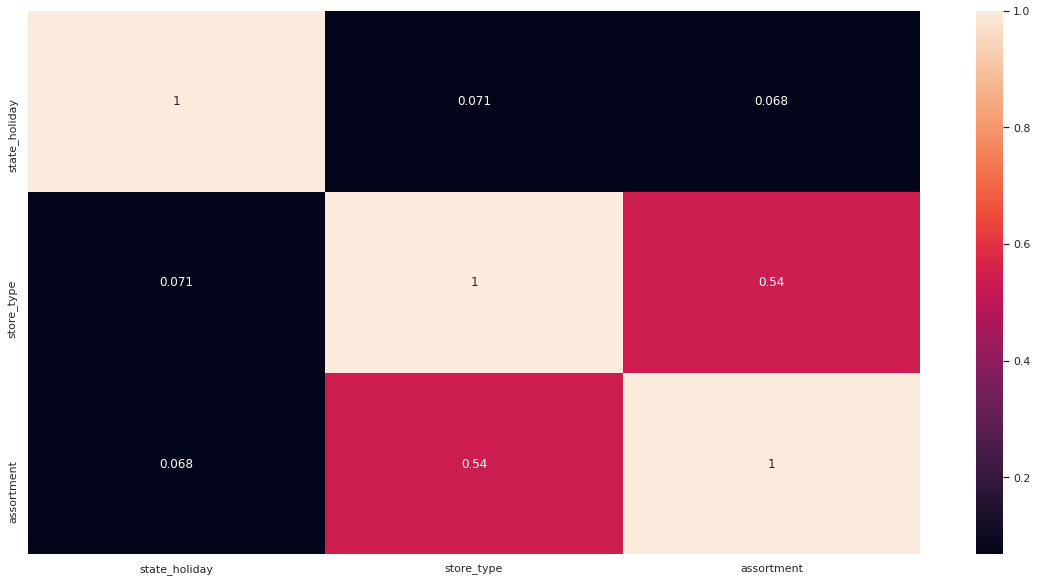

In [46]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [47]:
df5 = df4.copy()

## 5.1 Select Features

In [48]:
aux51 = df5.select_dtypes( include=['int64','float64'])
aux51.sample(3)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
782933,989,2,7276,1,0,1640.0,6,2006,1,40,2011,1,2013,7,30,31,87,96
58910,931,2,3660,0,0,1480.0,9,2011,1,1,2012,0,2015,6,9,24,45,180
914462,948,3,4597,0,1,1430.0,4,2013,0,14,2013,0,2013,4,3,14,0,0


Features selected for **Rescaling**:
   - competition distance
   - year
   - competition time month
   - promo time week

Features selected for **Transformation**:
   - Month
   - Day
   - Week of year
   - Day of week

## 5.2 Rescaling 

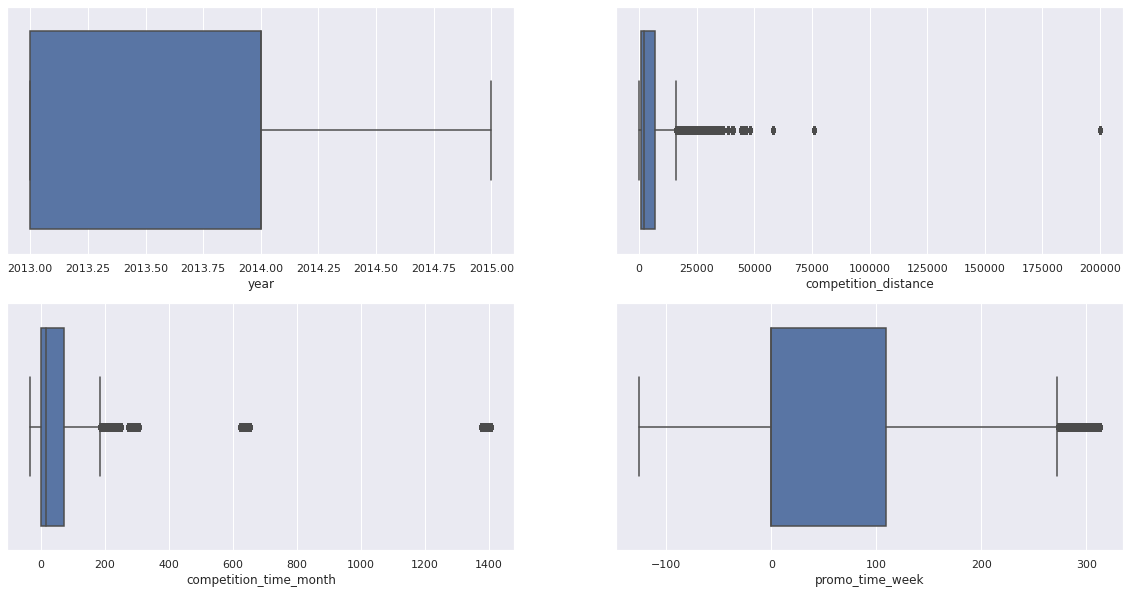

In [49]:
plt.subplot(2,2,1)
sns.boxplot(df5['year']);

plt.subplot(2,2,2)
sns.boxplot(df5['competition_distance']);


plt.subplot(2,2,3)
sns.boxplot(df5['competition_time_month']);

plt.subplot(2,2,4)
sns.boxplot(df5['promo_time_week']);

**Rosbust Scaler**:
    
   - Competition Distance
   - Competition time month

**Min Max Scaler**:
   - promo time week
   - year

In [50]:
#instantiate scalers
rs = RobustScaler()
mms = MinMaxScaler()

#Competition Distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

#Competition Time Month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )


#Promo Time Week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

#Year

df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3 Transformation

### 5.3.1 Encoding 

In [51]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

#assortment - Ordinal Encoding
assort = {'basic': 1, 'extra':2 , 'extended':3 }
df5['assortment'] = df5['assortment'].map( assort )



### 5.3.2 Response Variable 

In [52]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation 

In [53]:
#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )


#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

#week of year'

df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )
# day of week

df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )


# 6.0 Feature Selection 

In [54]:
df6 =  df5.copy()

## 6.1 Split training and test 

In [55]:
cols_drop = ['week_of_year' , 'day' , 'month' , 'day_of_week' ,'promo_since' ,'competition_since', 'year_week']
df6 = df6.drop( cols_drop ,axis=1)

In [56]:
#train dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']


#train dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Train min date {}'.format(  x_train['date'].min() ) )                                                          
print( 'Train max date {}'.format(  x_train['date'].max() ) )

print( '\ntest min date {}'.format(  x_test['date'].min() ) )
print( 'test max date {}'.format(  x_test['date'].max() ) )

Train min date 2013-01-01 00:00:00
Train max date 2015-06-18 00:00:00

test min date 2015-06-19 00:00:00
test max date 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

## 6.3 Manual Feature Selection

In [57]:
cols = ['store',
             'promo',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'competition_time_month',
             'promo_time_week',
             'month_cos',
             'month_sin',
             'day_sin',
             'day_cos',
             'week_of_year_cos',
             'week_of_year_sin',
             'year',
             'day_of_week_cos',
             'day_of_week_sin']

#columns to add
feat = ['date','sales']
cols_full = cols.copy()
cols_full.extend( feat )


# 7.0 Machine Learning

In [58]:
#data set cross validation
x_training = x_train[cols_full ]

#dataset
x_train = x_train[ cols ]
x_test = x_test[cols]


## 7.1 Base Line - Average Model

In [59]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales': 'predictions'} )
aux1 = pd.merge( aux1 , aux2 ,  how='left', on='store')
yhat_baseline = aux1['predictions']

#perfomance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.8,0.46,1835.14


## 7.2 Machine Learning Models 

In [60]:
#define models
lr  = LinearRegression( )
lrr = Lasso( alpha=0.01 )
rf  = RandomForestRegressor( n_estimators = 90, n_jobs=-1, random_state = 42) 
xgb = xgb.XGBRegressor( objective='reg:squarederror',
                        n_estimators=90,
                        eta= 0.01,
                        max_depth = 10,
                        subsample = 0.7)

models= [lr , lrr, rf , xgb]

#prediction
df_performance = get_model_performance(models, x_train, y_train, x_test, y_test )
df_performance = pd.concat([df_performance ,  baseline_result ]).reset_index().drop( 'index', axis=1)





TrainingLinearRegression...
TrainingLasso...
TrainingRandomForestRegressor...
TrainingXGBRegressor...


## 7.3 Compare Model's Performance 

In [61]:
df_performance.style.highlight_min(color='yellow')

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,1864.170000,0.290000,2692.720000
1,Lasso,1891.700000,0.290000,2744.450000
2,RandomForestRegressor,681.690000,0.100000,1012.790000
3,XGBRegressor,6769.430000,0.960000,7413.390000
4,Average Model,1354.800000,0.460000,1835.140000


## 7.4 Cross Validation 

In [62]:
#models
models = [lr ,lrr, rf , xgb]
#prediction
df = models_cross_validation(models, x_training  )

Training... LinearRegression...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... Lasso...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... RandomForestRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
Training... XGBRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1


## 7.5 Cross Validation Performance

In [63]:
df

,Model Name,MAE,MAPE,RMSE
0,LinearRegression KFold: 5,2541.82,0.32,3643.47
1,LinearRegression KFold: 4,1828.32,0.29,2594.47
2,LinearRegression KFold: 3,1795.64,0.3,2524.13
3,LinearRegression KFold: 2,2060.32,0.29,2973.0
4,LinearRegression KFold: 1,1978.13,0.28,2839.61
5,LinearRegression - Cross-Validation,2040.85 +/- 268.54,0.3 +/- 0.01,2914.94 +/- 398.81
6,Lasso KFold: 5,2751.45,0.31,3976.16
7,Lasso KFold: 4,1846.85,0.29,2630.9
8,Lasso KFold: 3,1808.43,0.29,2594.86
9,Lasso KFold: 2,2160.64,0.28,3168.02


As observed, **Random Forest Regressor** has lower **RMSE**

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search 

In [64]:
from sklearn.model_selection import RandomizedSearchCV

In [65]:
#number of trees in random forest
n_estimators = [ int(x) for x in np.linspace( start = 10, stop = 100, num = 11 )]

#number of features to consider at every split
max_features = ['auto','sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 11 )]
max_depth.append( None )
#Minimum number of sampĺes required to split a node
min_samples_split = [2, 5, 10]

#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4 ]

#Method of selecting samples for training each tree
bootstrap = [ True, False ]

random_grid = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split':min_samples_split,
                'min_samples_leaf':min_samples_leaf,
                'bootstrap': bootstrap 
}



In [66]:
import random

In [67]:
MAX = 10

for i in range( MAX ):
    #choose values
    rg = { k: random.sample( v, 1 )[0] for k, v in random_grid.items() }
    print("\n Parameter used in this Iteration ! ")
    print(rg)
 
    rf = RandomForestRegressor(random_state = 42,
                           n_jobs=-1,
                           n_estimators=rg['n_estimators'],
                           max_depth=rg['max_depth'],
                           min_samples_split=rg['min_samples_split'],
                           min_samples_leaf=rg['min_samples_leaf'],
                           bootstrap=rg['bootstrap'] )
    models = [rf]
    
    df = models_cross_validation(models, x_training )
    print( df )
    



 Parameter used in this Iteration ! 
{'n_estimators': 28, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}
Training... RandomForestRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2
Iteration 1
                                  Model Name                MAE           MAPE               RMSE
0            RandomForestRegressor  KFold: 5            1330.33           0.16            1969.67
1            RandomForestRegressor  KFold: 4             888.12           0.14             1346.6
2            RandomForestRegressor  KFold: 3              549.3           0.09             843.79
3            RandomForestRegressor  KFold: 2              858.1           0.11            1326.16
4            RandomForestRegressor  KFold: 1             707.74            0.1             1019.6
5  RandomForestRegressor - Cross-Validation   866.72 +/- 261.34  0.12 +/- 0.03  1301.16 +/- 384.2

 Parameter used in this Iteration ! 
{'n_estimators': 82, 'max_depth': 

Iteration 4
Iteration 3
Iteration 2
Iteration 1
                                  Model Name                MAE           MAPE               RMSE
0            RandomForestRegressor  KFold: 5             1679.3           0.21            2470.53
1            RandomForestRegressor  KFold: 4            1060.44           0.16            1624.68
2            RandomForestRegressor  KFold: 3             658.85           0.11             977.61
3            RandomForestRegressor  KFold: 2              973.2           0.13            1449.26
4            RandomForestRegressor  KFold: 1             828.04           0.12            1187.96
5  RandomForestRegressor - Cross-Validation   1039.97 +/- 347.5  0.15 +/- 0.04  1542.01 +/- 514.1


## 8.2 Final Model 

In [75]:

param_tuned = {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}

In [ ]:
#model
rf_tuned = RandomForestRegressor(random_state = 42,
                                 n_jobs=-1,
                                 n_estimators=param_tuned['n_estimators'],
                                 max_depth=param_tuned['max_depth'],
                                 min_samples_split=param_tuned['min_samples_split'],
                                 min_samples_leaf=param_tuned['min_samples_leaf'],
                                 bootstrap=param_tuned['bootstrap'] )
models = [rf_tuned]

#prediction
df_performance = models_cross_validation(models, x_training )
df_performance  

Training... RandomForestRegressor...
Iteration 5
Iteration 4
Iteration 3
Iteration 2


In [1]:
df

NameError: name 'df' is not defined